#  <center>Surface Crack Detection</center>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! unzip "/content/drive/MyDrive/Surface crack detection/Surface Crack Detection.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Positive/15001_1.jpg    
  inflating: Positive/15002_1.jpg    
  inflating: Positive/15003_1.jpg    
  inflating: Positive/15004_1.jpg    
  inflating: Positive/15005_1.jpg    
  inflating: Positive/15006_1.jpg    
  inflating: Positive/15007_1.jpg    
  inflating: Positive/15008_1.jpg    
  inflating: Positive/15009_1.jpg    
  inflating: Positive/15010_1.jpg    
  inflating: Positive/15011_1.jpg    
  inflating: Positive/15012_1.jpg    
  inflating: Positive/15013_1.jpg    
  inflating: Positive/15014_1.jpg    
  inflating: Positive/15015_1.jpg    
  inflating: Positive/15016_1.jpg    
  inflating: Positive/15017_1.jpg    
  inflating: Positive/15018_1.jpg    
  inflating: Positive/15019_1.jpg    
  inflating: Positive/15020_1.jpg    
  inflating: Positive/15021_1.jpg    
  inflating: Positive/15022_1.jpg    
  inflating: Positive/15023_1.jpg    
  inflating: Positive/15024_1.jpg    
  inflating: Positive/15025_1.jpg    

In [3]:
#Basic Python Libraries
import numpy as np
import pandas as pd
import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

#Basic Visualization 
import seaborn as sns
import matplotlib.pyplot as plt

import glob
from tqdm import tqdm
import time



#Image Classification
from PIL import Image 
from PIL import ImageEnhance
import cv2
#os.chdir(r"D:/Surface Crack Detection/")

<h3>Loading the Image dataset

In [4]:
PATH = "/content/"
POSITIVE  = '/content/Positive'
NEGATIVE = '/content/Negative'

In [5]:
positive = os.listdir(POSITIVE)
negative = os.listdir(NEGATIVE)

In [6]:
print(len(positive),len(negative))

20000 20000


In [7]:

data_path = []
label_for_path = []

In [8]:


def image_to_list(PATH_OF_IMAGE_FOLDER,PATH_OF_IMAGE):
    """
    ***Converts Image_path to The list and folder name as labels***
    params:
    PATH_OF_IMAGE_FOLDER:image path to store in data_path
    PATH_OF_IMAGE:folder name to store in labels
    
    returns
    no of image stored in data_path
    no of label stored in label_for_path
    
    """

    for image_path in glob.glob(PATH_OF_IMAGE_FOLDER):
        picture_path = str(image_path) +'/'
        print(picture_path)
        
        for i in PATH_OF_IMAGE:
            data_path.append(picture_path+i)
            label_for_path.append(os.path.basename(PATH_OF_IMAGE_FOLDER))

        return("No of images and labels in a list",len(data_path),len(label_for_path))

    
print(image_to_list(POSITIVE,positive))    
print(image_to_list(NEGATIVE,negative)) 

/content/Positive/
('No of images and labels in a list', 20000, 20000)
/content/Negative/
('No of images and labels in a list', 40000, 40000)


In [9]:
image_data =pd.DataFrame({"Image_Path":data_path,"Label":label_for_path})    
print(image_data.shape)
image_data.head(1)

(40000, 2)


,Image_Path,Label
0,/content/Positive/12226_1.jpg,Positive


In [10]:
image_data['Label'].unique()

array(['Positive', 'Negative'], dtype=object)

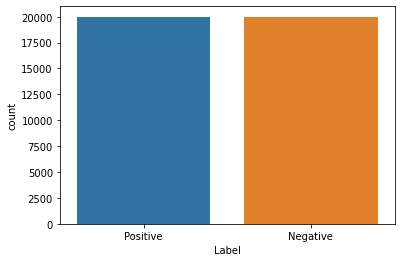

In [11]:
sns.countplot(image_data['Label'])

<h3>1.Preprocessing the image</h3>

For training and testing purposes of our model, we should have our data broken down into three distinct dataset splits.


**The Training Set**  =====> make the model learn the hidden features/patterns in the data.

**The Validation Set**  =====> helps us tune the model’s hyperparameters and configurations accordingly.

**The Test Set** =====>It provides an unbiased final model performance metric in terms of accuracy, precision, etc.



In [12]:
from sklearn.model_selection import train_test_split


train,test = train_test_split(image_data, train_size=.7, shuffle=True, random_state=1)



Creating the new directory to save images

In [13]:
os.makedirs('//content/' + "train")
os.makedirs('//content/' + "test")


Saving the image path to the list

In [14]:
train_FileNames = ['/train'+ name for name in train.Image_Path.tolist()]
val_FileNames = ['/test' + name for name in test.Image_Path.tolist()]

**Image Data Generator**

Random Rotations

Image rotation is one of the widely used augmentation techniques and allows the model to become invariant to the orientation of the object. ImageDataGenerator class allows you to randomly rotate images through any degree between 0 and 360 by providing an integer value in the rotation_range argument

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=45,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = .2)





test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split = .2)

In [16]:
train_data = train_datagen.flow_from_dataframe(
    train,
    x_col='Image_Path',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_datagen.flow_from_dataframe(
    train,
    x_col='Image_Path',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = test_datagen.flow_from_dataframe(
    test,
    x_col='Image_Path',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 22400 validated image filenames belonging to 2 classes.
Found 5600 validated image filenames belonging to 2 classes.
Found 12000 validated image filenames belonging to 2 classes.


# 2.Model Building

Convolutional Neural Network Model

In [17]:

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras import layers



In [18]:
# let's build the CNN model

#constants
INPUT_SHAPE = (120,120,3)
optimizer = keras.optimizers.Adam(learning_rate=0.01)


cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=INPUT_SHAPE))
cnn.add(MaxPool2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=INPUT_SHAPE))
cnn.add(MaxPool2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=INPUT_SHAPE))
cnn.add(MaxPool2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=INPUT_SHAPE))
cnn.add(MaxPool2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=INPUT_SHAPE))
cnn.add(MaxPool2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))


cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [19]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0

Fit Model

**Early Stopping** is a regularization technique for deep neural networks that stops training when parameter updates no longer begin to yield improves on a validation set. In essence, we store and update the current best parameters during training, and when parameter updates no longer yield an improvement (after a set number of iterations) we stop training and use the last best parameters. It works as a regularizer by restricting the optimization procedure to a smaller volume of parameter space.

In [20]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

**Class weighting** adjusts the cost function of the model so that misclassifying an observation from the minority class is more heavily penalized than misclassifying an observation from the majority class. This approach can help to improve the accuracy of the model by rebalancing the class distribution. 

In [62]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',classes= np.unique(train_data.classes),y = train_data.classes)
class_weight = dict(zip( np.unique(train_data.classes), weights))
print(class_weight)

{0: 0.9953785993601137, 1: 1.004664513814137}


In [74]:
cnn.fit(train_data,epochs=25, validation_data=val_data, class_weight=class_weight, callbacks=callbacks_list)

Epoch 1/25
700/700 [==============================] - 113s 161ms/step - loss: 0.0155 - accuracy: 0.9961 - val_loss: 0.0138 - val_accuracy: 0.9968 - lr: 8.1000e-06
Epoch 2/25
700/700 [==============================] - 113s 161ms/step - loss: 0.0144 - accuracy: 0.9961 - val_loss: 0.0128 - val_accuracy: 0.9968 - lr: 8.1000e-06
Epoch 3/25
700/700 [==============================] - 110s 157ms/step - loss: 0.0168 - accuracy: 0.9958 - val_loss: 0.0141 - val_accuracy: 0.9966 - lr: 8.1000e-06
Epoch 4/25
700/700 [==============================] - 109s 156ms/step - loss: 0.0155 - accuracy: 0.9960 - val_loss: 0.0114 - val_accuracy: 0.9970 - lr: 8.1000e-06
Epoch 5/25
700/700 [==============================] - 110s 157ms/step - loss: 0.0151 - accuracy: 0.9962 - val_loss: 0.0114 - val_accuracy: 0.9970 - lr: 8.1000e-06
Epoch 6/25
700/700 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9957
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
700/700 [====

Final Accuracy

In [75]:
train_acccuracy = np.mean(cnn.history.history['accuracy'])
test_acccuracy = np.mean(cnn.history.history['val_accuracy'])
print("The train accuracy is ",train_acccuracy)
print("The test accuracy is ",test_acccuracy)

The train accuracy is  0.996060274541378
The test accuracy is  0.9964285641908646


# 3.Model Loss

 **Model Loss** is a number indicating how bad the model's prediction was on a single example. If the model's prediction is perfect, the loss is zero; otherwise, the loss is greater. The goal of training a model is to find a set of weights and biases that have low loss, on average

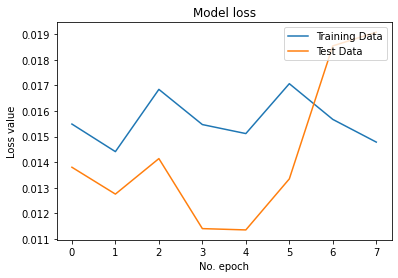

In [76]:

plt.plot(cnn.history.history['loss'], label='Training Data')
plt.plot(cnn.history.history['val_loss'], label='Test Data')
plt.title('Model loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

### Model Accuracy

the number of classifications a model correctly predicts divided by the total number of predictions made

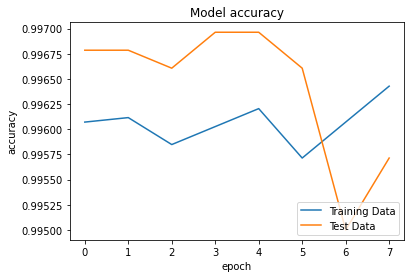

In [77]:


plt.plot(cnn.history.history['accuracy'], label='Training Data')
plt.plot(cnn.history.history['val_accuracy'], label='Test Data')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()


In [78]:
test_accu = cnn.evaluate(val_data)

175/175 [==============================] - 21s 122ms/step - loss: 0.0147 - accuracy: 0.9961


In [79]:
preds = cnn.predict(val_data,verbose=1)

175/175 [==============================] - 23s 129ms/step


In [89]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

Predicting a single images

In [90]:
image_path = "/content/Positive/00002.jpg"
from skimage import transform
import PIL
from PIL import Image
def load(filename):
  """***Convert the  images into numpy array***
  parameters:it takes the input as a file name
  returnss the array of an image  
  
  """

  np_image = Image.open(filename)
  np_image = np.array(np_image).astype('float32')/255
  np_image = transform.resize(np_image, (120, 120, 3))
  np_image = np.expand_dims(np_image, axis=0)
  return np_image
result = load(image_path)
#print(reslt)
predict_image = cnn.predict(result)
np.round(predict_image)

array([[1.]], dtype=float32)

Saving the models in a disk

In [82]:
path = "/content/models/"
file_name = "Surface_detection_cnn.h5"
model_path = os.path.join(path,file_name)
model_path

'/content/models/Surface_detection_cnn.h5'

In [83]:
cnn.save(filepath=model_path)
print(os.path.getsize('/content/models/Surface_detection_cnn.h5'))

1179096


Performance Report

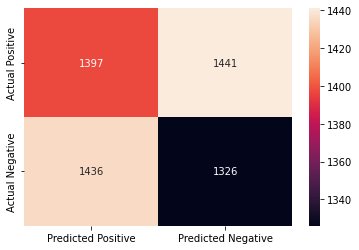

In [92]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(val_data.classes, predictions, labels=[1, 0]),
                  index=["Actual Positive", "Actual Negative"],
                  columns=["Predicted Positive", "Predicted Negative"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [94]:
 print(classification_report(y_true=val_data.classes, y_pred=predictions,
                            target_names =['Predicted Positive','Predicted Negative']
 ))

                    precision    recall  f1-score   support

Predicted Positive       0.48      0.48      0.48      2762
Predicted Negative       0.49      0.49      0.49      2838

          accuracy                           0.49      5600
         macro avg       0.49      0.49      0.49      5600
      weighted avg       0.49      0.49      0.49      5600



In [ ]:

from keras.preprocessing.image import load_img
image_path = "/content/Positive/00002.jpg"
my_image = load_img(image_path)
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (120, 120, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image
reslt = load(image_path)
#print(reslt)
predictions = cnn.predict(reslt)
predictions

In [ ]:
import numpy as np
[np.round(x) for x in predictions]


Final accuracy

Performance Report

In [ ]:
image_path = "/content/Negative/00592.jpg"
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (120, 120, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image
reslt = load(image_path)
#print(reslt)
predictions = model_vgg19.predict(reslt)
np.round(predictions)